Le but de ce notebook est de montrer comment on lance le module. 

1) On importe les éléments essentiels : 

In [1]:
from optimiser_engine.engine.service import Client, TrajectorySystem, OptimizerService 

Étape 1 : On crée un client. La méthode (par instanciation) est pénible. 
Au lieu de ça, On va utiliser les factorys. 
Il y a trois solutions : 
- from_dict (qui convertit un dict en un objet client) 
- from_yaml (convertit un str format Yaml en client) 
- from_yaml_file (convertit un fichier YAML en client) 

Ci dessous, on utilise la 2e, un fichier YAML exemplaire existe dans examples/client_sample.yaml 

In [2]:
# L'exemple de client (A modifier) : 
config = """
# Configuration d'un Client
client_id: 12345

water_heater:
  volume: 200.0            # En Litres
  power: 2500.0            # En Watts
  insulation_coeff: 0   # Optionnel (défaut 0). Perte en °C/min
  temp_cold_water: 10.0    # Optionnel (défaut 10). En °C

prices:
  mode: "HPHC"             # Choix : "BASE" ou "HPHC"
  hp_price: 0.25           # Prix du kWh en Heures Pleines
  hc_price: 0.15           # Prix du kWh en Heures Creuses
  #base_price: 0.20         # Utilisé seulement si mode = "BASE"
  resell_price: 0.10       # Prix de revente
  # Liste des créneaux HP (Format "HH:MM", obligatoire si mode HPHC)
  hp_slots:
    - start: "06:00"
      end: "22:00"

features:
  gradation: true          # true si le chauffe-eau supporte la modulation de puissance
  mode: "cost"             # Choix : "cost" (économique) ou "AutoCons" (autoconsommation)

constraints:
  min_temp: 40.0           # Température minimale de sécurité
  # Périodes où la chauffe est INTERDITE
  forbidden_slots:
    - start: "12:00"
      end: "14:00"
  
  # Profil de consommation (null = profil par défaut / bruit de fond)
  # Pour un profil personnalisé, fournir une liste de 7 listes de 24 valeurs
  consumption_profile: null
  background_noise : 400 #optionnel, pour une maison à puissance constante. 

planning:
  # Liste des besoins en eau chaude
  # day : 0 = Lundi, ... 6 = Dimanche
  - day: 0
    time: "18:15"          # Mettre entre guillemets pour éviter la confusion avec des minutes
    target_temp: 55.0
    volume: 10.0

  - day: 1
    time: "18:15"
    target_temp: 55.0
    volume: 10.0

  - day: 2
    time: "08:00"
    target_temp: 55.0
    volume: 10.0

  - day: 2
    time: "18:30"
    target_temp: 55.0
    volume: 10.0

  - day: 3
    time: "18:15"
    target_temp: 55.0
    volume: 10.0

  - day: 4
    time: "09:00"
    target_temp: 55.0
    volume: 10.0

  - day: 4
    time: "18:15"
    target_temp: 55.0
    volume: 10.0

  - day: 5
    time: "10:30"
    target_temp: 55.0
    volume: 10.0

  - day: 5
    time: "17:00"
    target_temp: 55.0
    volume: 10.0

  - day: 6
    time: "09:00"
    target_temp: 55.0
    volume: 10.0

  - day: 6
    time: "18:15"
    target_temp: 55.0
    volume: 10.0 """


In [3]:
client = Client.from_yaml(config) 

Etape 2 : Le contexte solaire de la simulation. 
Pour cela, il faut simplement préparer un DF qui contient deux colonnes, une colonne de dates, et une colonne de production PV (Les Watts solaires attendus). 

En revanche, si le DF contient des données trop espacés, si la date de simulation est différente de l'intervalle ... ça génère une erreur. 

In [4]:
# Exemple : On tire le DF du weather.csv  
from pathlib import Path 
import pandas as pd

# Définit le chemin racine.
BASE_DIR = Path.cwd()
data_path = BASE_DIR / "weather.csv" 

df = pd.read_csv(data_path, parse_dates=["date"]).set_index("date")



In [5]:
#On définit le datetime : 
from datetime import datetime 
date = datetime(2026, 1, 1, 0, 0) 
# Les deux derniers 0 peuvent être modifiées pour coller à l'heure réelle. 


In [6]:
#LA température initiale : 
temp_initiale = 45 
# ATTENTION : Si valeur irréaliste, une erreur va être levée. 

Maintenant, on appelle le OptimiserService : 

In [7]:
service = OptimizerService(horizon_hours=24, step_minutes=15) 
#On peut personnaliser le horizon et le step. 

Maintenant, on lance l'optimisation, celle ci génère un objet de type (TrajectorySystem) 

In [8]:
trajectoire_optimisee = service.trajectory_of_client(client, date, temp_initiale, df) 

/Users/anaselb/Dev/libs_optimasol/optimiser_engine_v2.0/src/optimiser_engine/engine/service.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  target_index = pd.date_range(


Maintenant, trajectoire_optimise est un objet complet, elle contient toutes les informations de la trajectoire (décisions, température, coût, ...) 

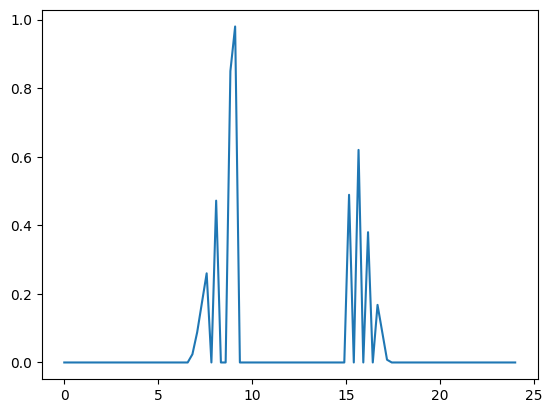

In [9]:
# Accès aux décisions : 
decisions = trajectoire_optimisee.get_decisions() 
# On les trace : 
import numpy as np 
# On trace les abcisses : 
N = len(decisions) 
temps = np.linspace(0, 24, N) 
import matplotlib.pyplot as plt 
plt.plot(temps, decisions )

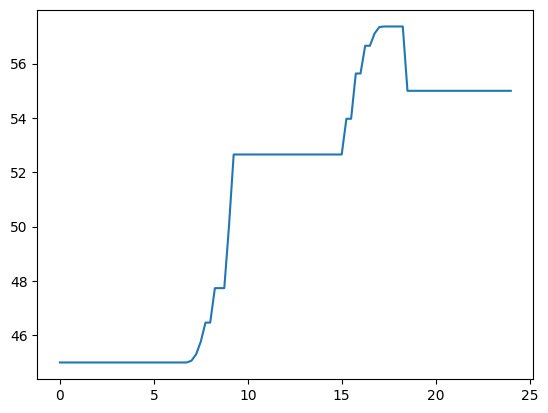

In [10]:
# Accès à la température : 
temperatures = trajectoire_optimisee.get_temperatures() 
# On la trace : 
temps = np.linspace(0,24,N+1)
plt.plot(temps, temperatures) 

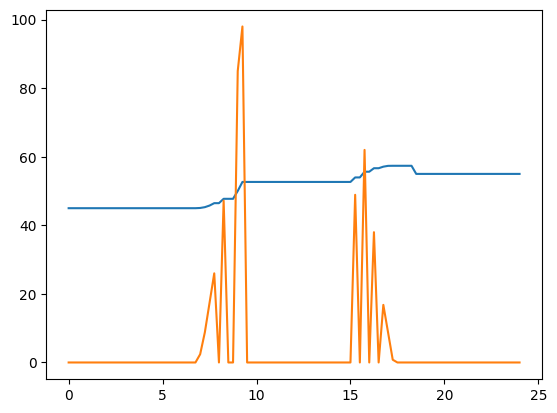

In [11]:
# On trace les deux : 
decisions_nouv = np.concatenate(([0], decisions)) 
plt.plot(temps, temperatures) 
plt.plot(temps, 100*decisions_nouv) 


In [12]:
# Savoir le coût, autoconsommation : 
cout = trajectoire_optimisee.compute_cost() 
autoconsommation = trajectoire_optimisee.compute_self_consumption() 
print(f"Coût : {cout} €") 
print(f"Autoconsommation : {autoconsommation*100} % ") 


Coût : -1.5814342105263164 €
Autoconsommation : 22.793993248849972 % 


Pour comparer avec Routeur Seul, Sans routeur, on utilise les méthodes qui génèrent des trajectoires. 
Mais pour cela, il faut indiquer des informations supplémentaires. 
Il y a deux types de chauffe eaux : 
 - Ceux qui chauffent une fois on est en dessous de T_consigne. 
 - Ceux qui rajoutent la contrainte de chauffer dans les HC seulement. 

In [13]:
from optimiser_engine.engine.service import StandardWHType 
#Deux choix : 
# 1) Pour le consigne classique : 
type = StandardWHType.SETPOINT 
# 2) 
type = StandardWHType.SETPOINT_OFF_PEAK

In [14]:
trajectoire_chauffe_eau = service.trajectory_of_client_standard(client, date, temp_initiale, df, None) 


/Users/anaselb/Dev/libs_optimasol/optimiser_engine_v2.0/src/optimiser_engine/engine/service.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  target_index = pd.date_range(
/Users/anaselb/Dev/libs_optimasol/optimiser_engine_v2.0/src/optimiser_engine/engine/models/trajectory.py:230: UpdateRequired: La partie décisions (x) du vecteur objectif X a été modifiée avec succès. Toutefois, il faut lancer la fonction update_X() afin de mettre à jour les autres éléments de X.Ceux-ci sont vides en ce moment (np.nan)
  warnings.warn("La partie décisions (x) du vecteur objectif X a été modifiée avec succès. " \


In [15]:
trajectoire_chauffe_eau.update_X()
#LE coût de ça : 
cout_chauffe_seul = trajectoire_chauffe_eau.compute_cost() 
autoconsommation_chauffe_seul = trajectoire_chauffe_eau.compute_self_consumption() 
print(f"Coût : {cout_chauffe_seul} €") 
print(f"Autoconsommation : {autoconsommation_chauffe_seul*100} %")

Coût : -1.33775 €
Autoconsommation : 13.990509719883667 %
